In [ ]:
# 初回だけ実行
# %pip install pandas
# %pip install wavedrom
# %pip install rp2040-pio-emulator@git+https://github.com/NathanY3G/rp2040-pio-emulator
# %pip install adafruit-circuitpython-pioasm

In [249]:
import re
from dataclasses import dataclass
import json
from typing import Any, Dict, List
import pandas as pd
from collections import deque
import itertools
import adafruit_pioasm
import pioemu
import wavedrom
import svgwrite


@dataclass
class EmulateResult:
    """PIOのエミュレーション結果を格納するクラス"""

    program_str: str
    test_cycles: int
    tx_fifo_entries: List[int]
    run_states_df: pd.DataFrame
    rx_fifo: List[int]
    wavedrom_src: str
    wave_svg: svgwrite.drawing.Drawing


def to_hex_u32(x: int) -> str:
    """32bit符号なし整数を16進数文字列に変換する"""
    return f"0x{(x& 0xffffffff):08X}"


def emulate_pio(
    program_str: str, test_cycles: int, tx_fifo_entries: List[int] = []
) -> EmulateResult:
    """PIOのエミュレーションを行う"""

    # emulation
    opcodes = adafruit_pioasm.assemble(program_str)
    test_cycles = 100
    generator = pioemu.emulate(
        opcodes=opcodes,
        stop_when=lambda _, state: state.clock > test_cycles,
        initial_state=pioemu.State(
            clock=0,
            program_counter=0,
            transmit_fifo=deque(tx_fifo_entries),
            receive_fifo=deque([]),
        ),
        wrap_top=0,
        wrap_target=len(opcodes) - 1,
        shift_isr_right=True,
        shift_osr_right=True,
    )

    # run
    run_states = [
        after.__dict__ for before, after in itertools.islice(generator, test_cycles)
    ]
    run_states_df = pd.DataFrame.from_records(run_states)
    rx_fifo = list(run_states_df[-1:]["receive_fifo"].values[0])

    # 欲しいデータ抽出

    def get_insert_idx() -> int:
        """DataFrameに新しい列を挿入するためのインデックスを返す"""

        dst = get_insert_idx.insert_idx  # increment前を返す
        get_insert_idx.insert_idx += 1
        return dst

    get_insert_idx.insert_idx = 0

    run_states_df.insert(
        get_insert_idx(),
        "cyc",
        run_states_df["clock"],
    )
    run_states_df.insert(
        get_insert_idx(),
        "pc",
        run_states_df["program_counter"],
    )
    run_states_df.insert(
        get_insert_idx(),
        "inst",
        run_states_df["pc"].map(lambda pc: to_hex_u32(opcodes[pc])),
    )
    run_states_df.insert(
        get_insert_idx(), "x", run_states_df["x_register"].map(to_hex_u32)
    )
    run_states_df.insert(
        get_insert_idx(), "y", run_states_df["y_register"].map(to_hex_u32)
    )
    run_states_df.insert(
        get_insert_idx(),
        "isr",
        run_states_df["input_shift_register"].map(lambda sr: to_hex_u32(sr.contents)),
    )
    run_states_df.insert(
        get_insert_idx(),
        "osr",
        run_states_df["output_shift_register"].map(lambda sr: to_hex_u32(sr.contents)),
    )
    run_states_df.insert(
        get_insert_idx(), "pindirs", run_states_df["pin_directions"].map(to_hex_u32)
    )
    run_states_df.insert(
        get_insert_idx(), "pins", run_states_df["pin_values"].map(to_hex_u32)
    )
    run_states_df.insert(
        get_insert_idx(),
        "io",
        run_states_df["pin_values"].map(
            lambda data: to_hex_u32((data & 0x000000FF) >> 0)
        ),
    )
    run_states_df.insert(
        get_insert_idx(),
        "ceb0",
        run_states_df["pin_values"].map(lambda data: (data & 0x00000100) >> 8),
    )
    run_states_df.insert(
        get_insert_idx(),
        "ceb1",
        run_states_df["pin_values"].map(lambda data: (data & 0x00000200) >> 9),
    )
    run_states_df.insert(
        get_insert_idx(),
        "cle",
        run_states_df["pin_values"].map(lambda data: (data & 0x00000400) >> 10),
    )
    run_states_df.insert(
        get_insert_idx(),
        "ale",
        run_states_df["pin_values"].map(lambda data: (data & 0x00000800) >> 11),
    )
    run_states_df.insert(
        get_insert_idx(),
        "wpb",
        run_states_df["pin_values"].map(lambda data: (data & 0x00001000) >> 12),
    )
    run_states_df.insert(
        get_insert_idx(),
        "web",
        run_states_df["pin_values"].map(lambda data: (data & 0x00002000) >> 13),
    )
    run_states_df.insert(
        get_insert_idx(),
        "reb",
        run_states_df["pin_values"].map(lambda data: (data & 0x00004000) >> 14),
    )
    run_states_df.insert(
        get_insert_idx(),
        "rbb",
        run_states_df["pin_values"].map(lambda data: (data & 0x00008000) >> 15),
    )
    run_states_df.insert(
        get_insert_idx(),
        "led",
        run_states_df["pin_values"].map(lambda data: (data & 0x01000000) >> 24),
    )

    # シーケンス解析
    run_states_df["cs_assert"] = (run_states_df["ceb0"] == 0) | (run_states_df["ceb1"] == 0) 
    run_states_df["web_edge"] = (run_states_df["web"] == 1) & (
        run_states_df["web"].shift(-1) == 0
    )  # rising edge
    run_states_df["reb_edge"] = (run_states_df["reb"] == 0) & (
        run_states_df["reb"].shift(-1) == 1
    )  # falling edge
    run_states_df.insert(
        get_insert_idx(),
        "cmd_in",
        run_states_df["web_edge"]
        & run_states_df["cs_assert"]
        & (run_states_df["web"] == 0)
        & (run_states_df["reb"] == 1)
        & (run_states_df["cle"] == 1)
        & (run_states_df["ale"] == 0),
    )
    run_states_df.insert(
        get_insert_idx(),
        "addr_in",
        run_states_df["web_edge"]
        & run_states_df["cs_assert"]
        & (run_states_df["web"] == 0)
        & (run_states_df["reb"] == 1)
        & (run_states_df["cle"] == 0)
        & (run_states_df["ale"] == 1),
    )
    run_states_df.insert(
        get_insert_idx(),
        "data_in",
        run_states_df["web_edge"]
        & run_states_df["cs_assert"]
        & (run_states_df["web"] == 0)
        & (run_states_df["reb"] == 1)
        & (run_states_df["cle"] == 0)
        & (run_states_df["ale"] == 0),
    )
    run_states_df.insert(
        get_insert_idx(),
        "data_out",
        run_states_df["reb_edge"]
        & run_states_df["cs_assert"]
        & (run_states_df["web"] == 1)
        & (run_states_df["reb"] == 0)
        & (run_states_df["cle"] == 0)
        & (run_states_df["ale"] == 0),
    )

    def to_wavedrom_signal(df: pd.DataFrame, col: str) -> Dict[str, Any]:
        """DataFrameの列をWavedromの信号に変換する"""
        src = df[col].map(lambda x: "1" if x else "0").to_list()
        dst_wave = []

        prev_data = None
        for entry in src:
            if prev_data == entry:
                dst_wave.append(".")
            else:
                dst_wave.append(entry)
                prev_data = entry
        return {"name": col, "wave": "".join(dst_wave)}

    def to_wavedrom_data(df: pd.DataFrame, col: str) -> Dict[str, Any]:
        """DataFrameの列をWavedromの信号に変換する"""
        src = df[col].to_list()
        dst_wave = []
        dst_data = []

        prev_data = None
        for entry in src:
            if prev_data == entry:
                dst_wave.append(".")
            else:
                dst_wave.append("=")
                dst_data.append(
                    hex(
                        int(entry, 16),
                    ).replace("0x", "")
                    if isinstance(entry, str)
                    else entry
                )  # 長いので縮める, str|intの場合分け
                prev_data = entry
        return {"name": col, "wave": "".join(dst_wave), "data": dst_data}

    wavedrom_src = json.dumps(
        {
            "signal": [
                to_wavedrom_data(run_states_df, "cyc"),
                to_wavedrom_data(run_states_df, "pc"),
                to_wavedrom_data(run_states_df, "inst"),
                to_wavedrom_data(run_states_df, "x"),
                to_wavedrom_data(run_states_df, "y"),
                to_wavedrom_data(run_states_df, "isr"),
                to_wavedrom_data(run_states_df, "osr"),
                to_wavedrom_data(run_states_df, "pindirs"),
                to_wavedrom_data(run_states_df, "pins"),
                {},
                to_wavedrom_signal(run_states_df, "ceb0"),
                to_wavedrom_signal(run_states_df, "ceb1"),
                to_wavedrom_signal(run_states_df, "cle"),
                to_wavedrom_signal(run_states_df, "ale"),
                to_wavedrom_signal(run_states_df, "web"),
                to_wavedrom_signal(run_states_df, "reb"),
                to_wavedrom_data(run_states_df, "io"),
                {},
                to_wavedrom_signal(run_states_df, "wpb"),
                to_wavedrom_signal(run_states_df, "rbb"),
            ]
        }
    )
    wave_svg = wavedrom.render(wavedrom_src)

    return EmulateResult(
        program_str=program_str,
        test_cycles=test_cycles,
        tx_fifo_entries=tx_fifo_entries,
        run_states_df=run_states_df,
        rx_fifo=rx_fifo,
        wavedrom_src=wavedrom_src,
        wave_svg=wave_svg,
    )


tx_fifo_entries: ['0x2007fff', '0x3', '0x6300', '0x46ff', '0x66ff', '0x6300', '0x2007fff', '0x5', '0x6300', '0x4690', '0x6690', '0x4a00', '0x6200', '0x6300']
rx_fifo: []
wavedrom_src: {"signal": [{"name": "cyc", "wave": "====================================================================================================", "data": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]}, {"name": "pc", "wave": "===============.=========================...........................................................", "data": [1, 2, 3, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 4]}, {"name": "inst"

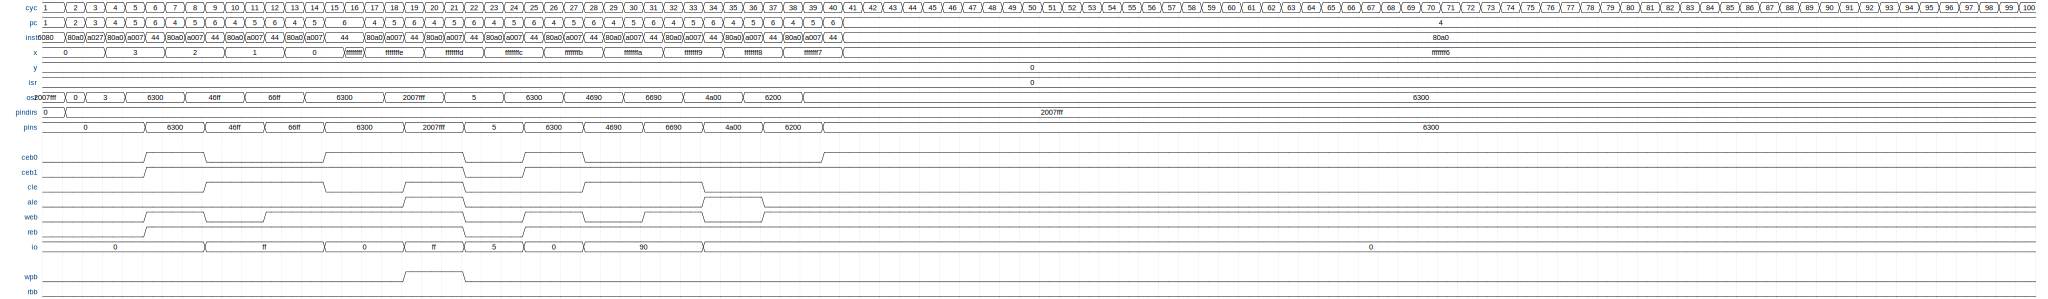

,cyc,pc,inst,x,y,isr,osr,pindirs,pins,io,ceb0,ceb1,cle,ale,wpb,web,reb,rbb,led,cmd_in,addr_in,data_in,data_out,clock,program_counter,pin_directions,pin_values,transmit_fifo,receive_fifo,input_shift_register,output_shift_register,x_register,y_register,cs_assert,web_edge,reb_edge
0,1,1,0x00006080,0x00000000,0x00000000,0x00000000,0x02007FFF,0x00000000,0x00000000,0x00000000,0,0,0,0,0,0,0,0,0,False,False,False,False,1,1,0,0,"[3, 25344, 18175, 26367, 25344, 33587199, 5, 2...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=33587199, counter=0)",0,0,True,False,False
1,2,2,0x000080A0,0x00000000,0x00000000,0x00000000,0x00000000,0x02007FFF,0x00000000,0x00000000,0,0,0,0,0,0,0,0,0,False,False,False,False,2,2,33587199,0,"[3, 25344, 18175, 26367, 25344, 33587199, 5, 2...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=0, counter=32)",0,0,True,False,False
2,3,3,0x0000A027,0x00000000,0x00000000,0x00000000,0x00000003,0x02007FFF,0x00000000,0x00000000,0,0,0,0,0,0,0,0,0,False,False,False,False,3,3,33587199,0,"[25344, 18175, 26367, 25344, 33587199, 5, 2534...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=3, counter=0)",0,0,True,False,False
3,4,4,0x000080A0,0x00000003,0x00000000,0x00000000,0x00000003,0x02007FFF,0x00000000,0x00000000,0,0,0,0,0,0,0,0,0,False,False,False,False,4,4,33587199,0,"[25344, 18175, 26367, 25344, 33587199, 5, 2534...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=3, counter=0)",3,0,True,False,False
4,5,5,0x0000A007,0x00000003,0x00000000,0x00000000,0x00006300,0x02007FFF,0x00000000,0x00000000,0,0,0,0,0,0,0,0,0,False,False,False,False,5,5,33587199,0,"[18175, 26367, 25344, 33587199, 5, 25344, 1806...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=25344, counter=0)",3,0,True,False,True
8,9,6,0x00000044,0x00000002,0x00000000,0x00000000,0x000046FF,0x02007FFF,0x000046FF,0x000000FF,0,1,1,0,0,0,1,0,0,False,False,False,False,9,6,33587199,18175,"[26367, 25344, 33587199, 5, 25344, 18064, 2625...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=18175, counter=0)",2,0,True,False,False
9,10,4,0x000080A0,0x00000001,0x00000000,0x00000000,0x000046FF,0x02007FFF,0x000046FF,0x000000FF,0,1,1,0,0,0,1,0,0,False,False,False,False,10,4,33587199,18175,"[26367, 25344, 33587199, 5, 25344, 18064, 2625...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=18175, counter=0)",1,0,True,False,False
10,11,5,0x0000A007,0x00000001,0x00000000,0x00000000,0x000066FF,0x02007FFF,0x000046FF,0x000000FF,0,1,1,0,0,0,1,0,0,False,False,False,False,11,5,33587199,18175,"[25344, 33587199, 5, 25344, 18064, 26256, 1894...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=26367, counter=0)",1,0,True,False,False
11,12,6,0x00000044,0x00000001,0x00000000,0x00000000,0x000066FF,0x02007FFF,0x000066FF,0x000000FF,0,1,1,0,0,1,1,0,0,False,False,False,False,12,6,33587199,26367,"[25344, 33587199, 5, 25344, 18064, 26256, 1894...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=26367, counter=0)",1,0,True,False,False
12,13,4,0x000080A0,0x00000000,0x00000000,0x00000000,0x000066FF,0x02007FFF,0x000066FF,0x000000FF,0,1,1,0,0,1,1,0,0,False,False,False,False,13,4,33587199,26367,"[25344, 33587199, 5, 25344, 18064, 26256, 1894...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=26367, counter=0)",0,0,True,False,False


In [257]:
from typing import List, Optional
import pandas as pd
from enum import Enum
from IPython.display import display


class NandPinAssign(Enum):
    """
    NAND IC Interconnect
    | 31  | 30  | 29  | 28  | 27  | 26  | 25  | 24  | 23  | 22  | 21  | 20  | 19  | 18  | 17  | 16  | 15  | 14  | 13  | 12  | 11  | 10  | 9    | 8    | 7   | 6   | 5   | 4   | 3   | 2   | 1   | 0   |
    | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---- | ---- | --- | --- | --- | --- | --- | --- | --- | --- |
    | --  | --  | --  | --  | --  | --  | led | --  | --  | --  | --  | --  | --  | --  | --  | --  | rbb | reb | web | wpb | ale | cle | ceb1 | ceb0 | io7 | io6 | io5 | io4 | io3 | io2 | io1 | io0 |
    """

    Io0 = 0
    Io1 = 1
    Io2 = 2
    Io3 = 3
    Io4 = 4
    Io5 = 5
    Io6 = 6
    Io7 = 7
    Ceb0 = 8
    Ceb1 = 9
    Cle = 10
    Ale = 11
    Wpb = 12
    Web = 13
    Reb = 14
    Rbb = 15
    Led = 25


# 指定したbitだけ1の値
def bit_on(bit_pos: int) -> int:
    return 0x01 << bit_pos


# RBB以外全部Output
write_pin_dir = (
    bit_on(NandPinAssign.Led.value)
    | bit_on(NandPinAssign.Reb.value)
    | bit_on(NandPinAssign.Web.value)
    | bit_on(NandPinAssign.Wpb.value)
    | bit_on(NandPinAssign.Ale.value)
    | bit_on(NandPinAssign.Cle.value)
    | bit_on(NandPinAssign.Ceb1.value)
    | bit_on(NandPinAssign.Ceb0.value)
    | bit_on(NandPinAssign.Io7.value)
    | bit_on(NandPinAssign.Io6.value)
    | bit_on(NandPinAssign.Io5.value)
    | bit_on(NandPinAssign.Io4.value)
    | bit_on(NandPinAssign.Io3.value)
    | bit_on(NandPinAssign.Io2.value)
    | bit_on(NandPinAssign.Io1.value)
    | bit_on(NandPinAssign.Io0.value)
)

# RBB,IO以外Output
read_pin_dir = (
    bit_on(NandPinAssign.Led.value)
    | bit_on(NandPinAssign.Reb.value)
    | bit_on(NandPinAssign.Web.value)
    | bit_on(NandPinAssign.Wpb.value)
    | bit_on(NandPinAssign.Ale.value)
    | bit_on(NandPinAssign.Cle.value)
    | bit_on(NandPinAssign.Ceb1.value)
    | bit_on(NandPinAssign.Ceb0.value)
)

# Assert=/WP, Negate=/CS,/RE,/WE,/CLE,ALE,
init_pin_state = (
    bit_on(NandPinAssign.Reb.value)
    | bit_on(NandPinAssign.Web.value)
    | bit_on(NandPinAssign.Ceb1.value)
    | bit_on(NandPinAssign.Ceb0.value)
)


# CS0, CS1設定
def get_ceb0_pin_state(select_cs: Optional[int] = None) -> int:
    if select_cs is None:
        return bit_on(NandPinAssign.Ceb0.value) | bit_on(NandPinAssign.Ceb1.value)
    elif select_cs == 0:
        return bit_on(NandPinAssign.Ceb1.value)
    elif select_cs == 1:
        return bit_on(NandPinAssign.Ceb0.value)
    else:
        raise ValueError("select_cs must be 0 or 1 or None")


# PIO Assembler
program = """
.program pio-nandio-readid
.wrap_target
    ; tx fifo -> pindirs: for pindir
    pull block
    out pindirs, 32

    ; tx fifo -> x; bitbang loop counter
    pull block
    mov x, osr

bitbang_loop:
    ; tx fifo -> pins; cmd
    pull block
    mov pins, osr
    jmp x-- bitbang_loop
.wrap
"""

tx_fifo_entries = [
    #############################################
    ### RESET ###
    # pindir
    write_pin_dir,
    # transfer count (-1指定する)
    4-1,
    # init pin state
    init_pin_state,
    # Reset Cmd
    0xff
    | get_ceb0_pin_state(0)
    | bit_on(NandPinAssign.Cle.value)
    | bit_on(NandPinAssign.Reb.value),
    0xff
    | get_ceb0_pin_state(0)
    | bit_on(NandPinAssign.Cle.value)
    | bit_on(NandPinAssign.Web.value)
    | bit_on(NandPinAssign.Reb.value),
    # init pin state
    init_pin_state,

    #############################################
    ### READ ID ###
    # pindir
    write_pin_dir,
    # transfer count (-1指定する)
    6-1,
    # init pin state
    init_pin_state,
    # Read ID Cmd
    0x90
    | get_ceb0_pin_state(0)
    | bit_on(NandPinAssign.Cle.value)
    | bit_on(NandPinAssign.Reb.value),
    0x90
    | get_ceb0_pin_state(0)
    | bit_on(NandPinAssign.Cle.value)
    | bit_on(NandPinAssign.Web.value)
    | bit_on(NandPinAssign.Reb.value),
    # Address 00
    0x00
    | get_ceb0_pin_state(0)
    | bit_on(NandPinAssign.Ale.value)
    | bit_on(NandPinAssign.Reb.value),
    0x00
    | get_ceb0_pin_state(0)
    | bit_on(NandPinAssign.Web.value)
    | bit_on(NandPinAssign.Reb.value),
    # init pin state
    init_pin_state,
]

result = emulate_pio(program, test_cycles=100, tx_fifo_entries=tx_fifo_entries)

print(f"tx_fifo_entries: {[hex(x) for x in result.tx_fifo_entries]}")
print(f"rx_fifo: {result.rx_fifo}")
print(f"wavedrom_src: {result.wavedrom_src}")

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

display(result.wave_svg)
display(result.run_states_df.query("cs_assert"))
